* Name: Sandeep Kumar Kushwaha
* Email: sandeepkumar998855@gmail.com
* LinkedIn: https://www.linkedin.com/in/xandie985/

## Air Pollution Forecasting
We are going to build a simple neural network to forecast the Benzene concentration in air.

The dataset contains  hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device and ground truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) provided by a co-located reference certified analyzer. 
Missing values are tagged with -200 value.

Attribute Information:

1.   Date (DD/MM/YYYY)
2.   Time (HH.MM.SS)
3.   True hourly averaged concentration CO in mg/m^3 (reference analyzer)
4.   PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
5.   True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
6.   True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
7.   PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
8.   True hourly averaged NOx concentration in ppb (reference analyzer)
9.   PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
10.  True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
11.  PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
12.  PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
13.  Temperature in °C
14.  Relative Humidity (%)
15.  AH Absolute Humidity


*   Load the dataset and perform the standard steps you would do in any data science project, e.g: data exploration, data cleaning, preprocessing etc.
*   Train and evaluate a neural network for **time series** (RNN or similar) to predict Benzene concentration at the 
next hour. You can use  Pytorch, Tensowflow(Keras) or Theano.
*   How would you apply cross validation to the model? (No code implementation required, just description of the methodology)

Explain each of these steps and discuss the results.


In [570]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [571]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from tabulate import tabulate
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [572]:
df = pd.read_csv('AirQualityUCI.csv', sep = ';')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-11,00:00:00,1.2,1185.00,31,3.624399,689.50,62.0,1461.75,77.0,1332.75,732.50,11.325,56.775000,0.760312
1,2004-03-11,01:00:00,1.0,1136.25,31,3.326677,672.00,62.0,1453.25,76.0,1332.75,729.50,10.675,60.000000,0.770238
2,2004-03-11,02:00:00,0.9,1094.00,24,2.339416,608.50,45.0,1579.00,60.0,1276.00,619.50,10.650,59.674999,0.764819
3,2004-03-11,03:00:00,0.6,1009.75,19,1.696658,560.75,-200.0,1705.00,-200.0,1234.75,501.25,10.250,60.200001,0.751657
4,2004-03-11,04:00:00,-200.0,1011.00,14,1.293620,526.75,21.0,1817.50,34.0,1196.75,445.25,10.075,60.474999,0.746495


## Data Exploration and Cleaning

In [573]:
df.shape

(9312, 15)

In [574]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9312 entries, 0 to 9311
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9312 non-null   object 
 1   Time           9312 non-null   object 
 2   CO(GT)         9312 non-null   float64
 3   PT08.S1(CO)    9312 non-null   float64
 4   NMHC(GT)       9312 non-null   int64  
 5   C6H6(GT)       9312 non-null   float64
 6   PT08.S2(NMHC)  9312 non-null   float64
 7   NOx(GT)        9312 non-null   float64
 8   PT08.S3(NOx)   9312 non-null   float64
 9   NO2(GT)        9312 non-null   float64
 10  PT08.S4(NO2)   9312 non-null   float64
 11  PT08.S5(O3)    9312 non-null   float64
 12  T              9312 non-null   float64
 13  RH             9312 non-null   float64
 14  AH             9312 non-null   float64
dtypes: float64(12), int64(1), object(2)
memory usage: 1.1+ MB


In [575]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000,9312.000000
mean,-34.358688,1048.804840,-159.076997,1.844422,894.980258,168.477749,794.555198,57.864014,1392.627542,975.505897,9.741395,39.483301,-6.873899
std,77.786626,330.391141,139.959492,41.477608,342.764079,257.870325,322.401672,127.142334,467.641165,457.329092,43.302083,51.325604,39.067237
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,920.750000,-200.000000,4.014000,711.500000,50.000000,636.687500,53.000000,1187.500000,700.687500,10.931250,34.075000,0.694252
50%,1.500000,1052.750000,-200.000000,7.910799,895.500000,141.000000,793.750000,96.000000,1447.000000,942.375000,17.225000,48.550000,0.979774
75%,2.600000,1221.312500,-200.000000,13.668488,1105.812500,284.725000,960.062500,133.000000,1662.562500,1255.750000,24.075000,61.956250,1.298926
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [576]:
df.isnull().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [577]:
cols = list(df.columns)
cols

['Date',
 'Time',
 'CO(GT)',
 'PT08.S1(CO)',
 'NMHC(GT)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'NOx(GT)',
 'PT08.S3(NOx)',
 'NO2(GT)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'RH',
 'AH']

In [578]:
#merging relevant columns together as one.
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)
# Removing redundant columns
df.drop(['Date', 'Time'], axis = 1, inplace=True)

df.columns


Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

#### Setting target column

In [579]:
df_target = df['C6H6(GT)']
df_target.head()

Datetime
2004-03-11 00:00:00    3.624399
2004-03-11 01:00:00    3.326677
2004-03-11 02:00:00    2.339416
2004-03-11 03:00:00    1.696658
2004-03-11 04:00:00    1.293620
Name: C6H6(GT), dtype: float64

Checking correlation between the columns now. 

In [580]:
correlation_matrix = df.corr()

#correlations with the target feature
correlation_with_target = correlation_matrix['C6H6(GT)'].drop('C6H6(GT)')
print('correlation_with_target: ', correlation_with_target)


correlation_with_target:  CO(GT)          -0.031652
PT08.S1(CO)      0.853016
NMHC(GT)         0.037306
PT08.S2(NMHC)    0.768121
NOx(GT)         -0.001467
PT08.S3(NOx)     0.512860
NO2(GT)         -0.011354
PT08.S4(NO2)     0.775872
PT08.S5(O3)      0.642101
T                0.971446
RH               0.925394
AH               0.984603
Name: C6H6(GT), dtype: float64


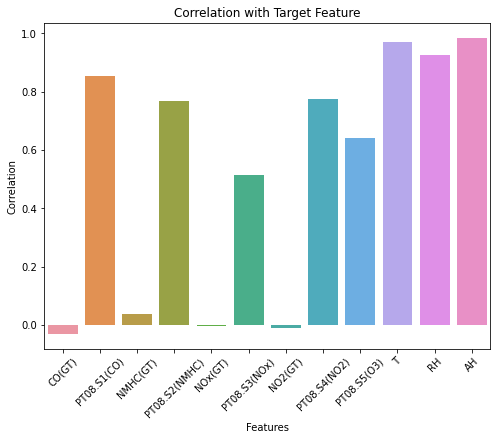

In [581]:
#Plotting correlation values
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.title('Correlation with Target Feature')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()


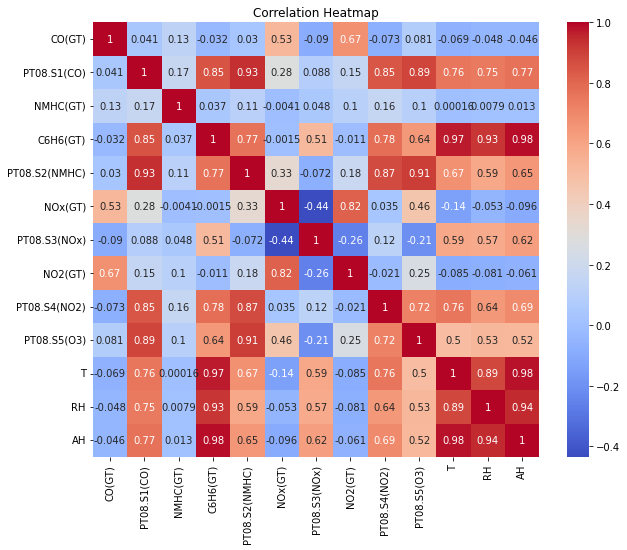

In [582]:
# Lets visualize the correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [583]:
# Set lower correlation threshold for feature selection 
lower_correlation_threshold = 0.6
# Set upper correlation threshold for feature selection 
upper_correlation_threshold = 0.95
# Select relevant features based on correlation threshold
relevant_features = correlation_with_target[(abs(correlation_with_target) >= lower_correlation_threshold) & (abs(correlation_with_target) <= upper_correlation_threshold)]

# Replacing original df with relevant features only
df = df[relevant_features.index]

# Print the relevant features
print("Relevant Features:")
print(df.columns)

Relevant Features:
Index(['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'RH'], dtype='object')


In [584]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S4(NO2),PT08.S5(O3),RH
Datetime,,,,,
2004-03-11 00:00:00,1185.00,689.50,1332.75,732.50,56.775000
2004-03-11 01:00:00,1136.25,672.00,1332.75,729.50,60.000000
2004-03-11 02:00:00,1094.00,608.50,1276.00,619.50,59.674999
2004-03-11 03:00:00,1009.75,560.75,1234.75,501.25,60.200001
2004-03-11 04:00:00,1011.00,526.75,1196.75,445.25,60.474999


#### features before handling outliers

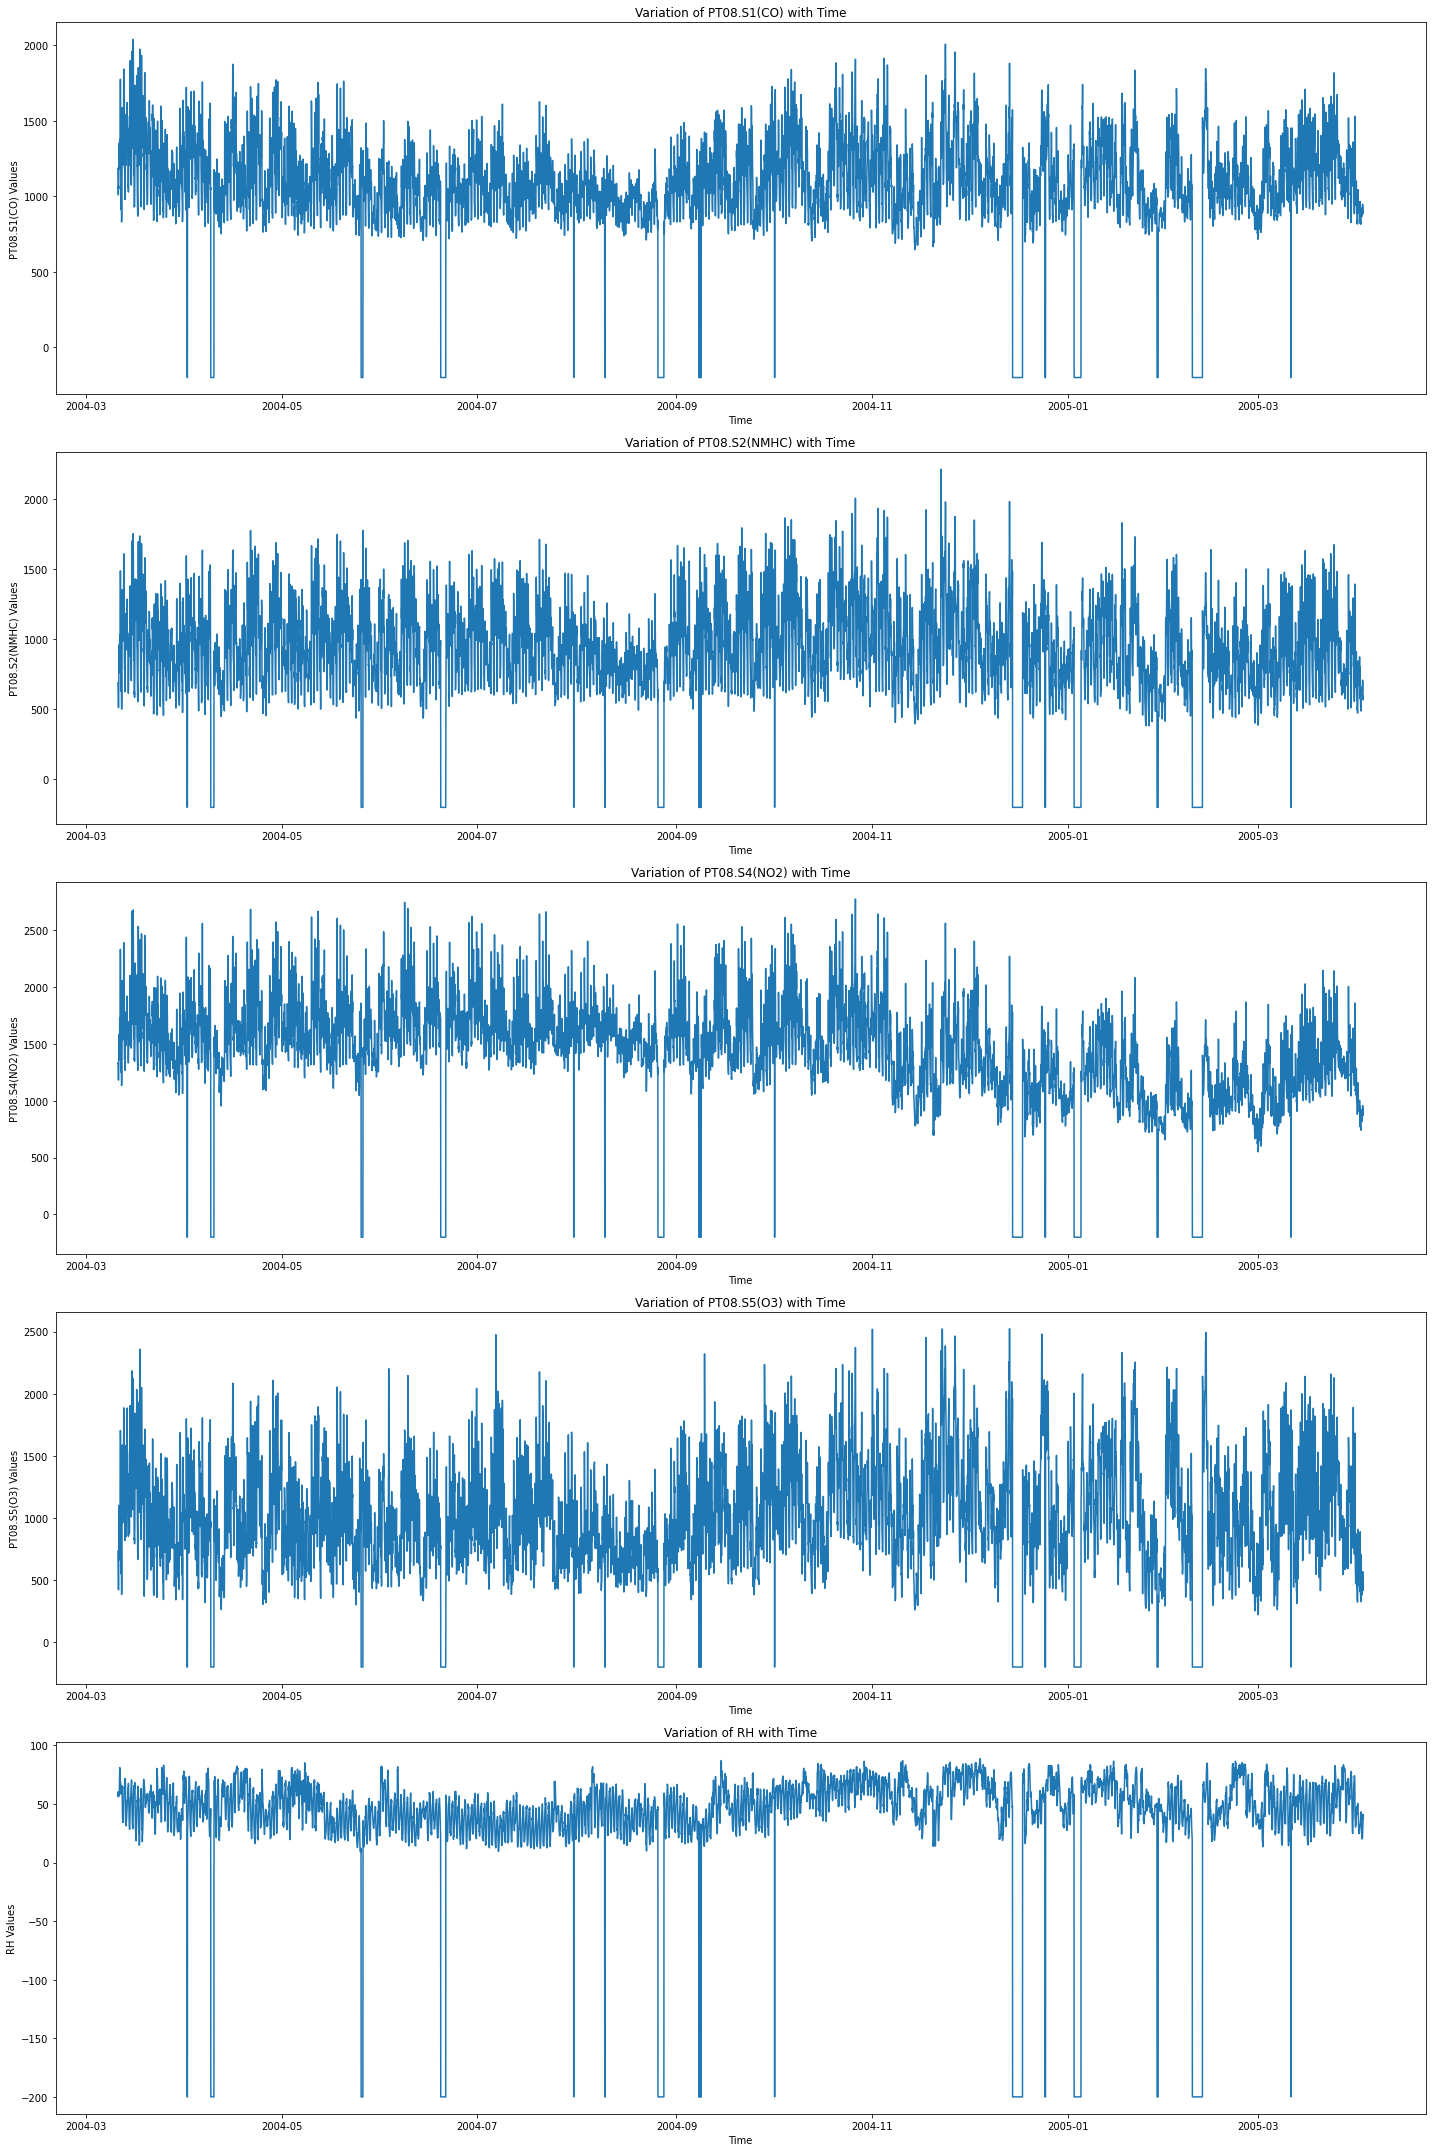

In [585]:
num_features = len(df.columns)

# Create a grid of subplots
fig, axes = plt.subplots(num_features, 1, figsize=(20, 6*num_features))  # Adjust the figure size as per your preference

for i, feature in enumerate(df.columns[:]):
    axes[i].plot(df[feature])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{feature} Values')
    axes[i].set_title(f'Variation of {feature} with Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

#### Dealing with outliers and imputing values. 

MULTIPLE IMPUTATION

In [586]:
# IQR outlier detection function: instead of upper limit at 75%, setting it to 100% to consider all valid points
# outliers are present at the bottom only
def detect_outliers_iqr(data, threshold=1.5):
    # Calculate the IQR
    q25, q100 = np.percentile(data, [25, 100])
    iqr = q100 - q25
    
    # the lower and upper bounds for outliers
    lower_bound = q25 - (iqr * threshold)
    upper_bound = q100 + (iqr * threshold)
    
    # outlier detection
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers


# function to replace outliers with linear imputation
def replace_outliers_linear_imputation(data, outliers):
    # Create a copy of the data
    data_imputed = data.copy()
    
    # indices of the outliers
    outlier_indices = np.where(outliers)[0]
    
    # prform linear imputation by filling outliers with the mean of non-outliers
    non_outlier_mean = np.mean(data[~outliers])
    data_imputed[outliers] = non_outlier_mean
    return data_imputed

# the function to replace outliers with interpolated values using CubicSpline
def replace_outliers_interpolate(data, outliers):
    # backup of the data
    data_interpolated = data.copy()
    
    # indices of the outliers
    outlier_indices = np.where(outliers)[0]
    
    # Generate the indices of the non-outliers
    non_outlier_indices = np.arange(len(data))
    non_outlier_indices = np.delete(non_outlier_indices, outlier_indices)
    
    # time series interpolation using CubicSpline
    spline = CubicSpline(non_outlier_indices, data[non_outlier_indices])
    interpolated_values = spline(outlier_indices)
    
    # Replace outliers with the interpolated values
    data_interpolated[outliers] = interpolated_values
    return data_interpolated

# the function to replace outliers with nearest neighbor interpolation
def replace_outliers_nearest_neighbor(data, outliers):
    # backup data
    data_imputed = data.copy()
    
    # indices of the outliers
    outlier_indices = np.where(outliers)[0]
    
    for idx in outlier_indices:
        # the nearest neighbor index with a non-outlier value
        nearest_neighbor_idx = np.argmin(np.abs(idx - np.where(~outliers)[0]))
        
        # replace the outlier with the value of the nneighbour
        data_imputed[idx] = data_imputed[nearest_neighbor_idx]
    
    return data_imputed


# since all the colummns are time series data
for col in df.columns:
    # Detect outliers using IQR
    outliers = detect_outliers_iqr(df[col])
    # print(outliers)

    # Replace outliers with interpolated values using CubicSpline
    df[col] = replace_outliers_nearest_neighbor(df[col], outliers)


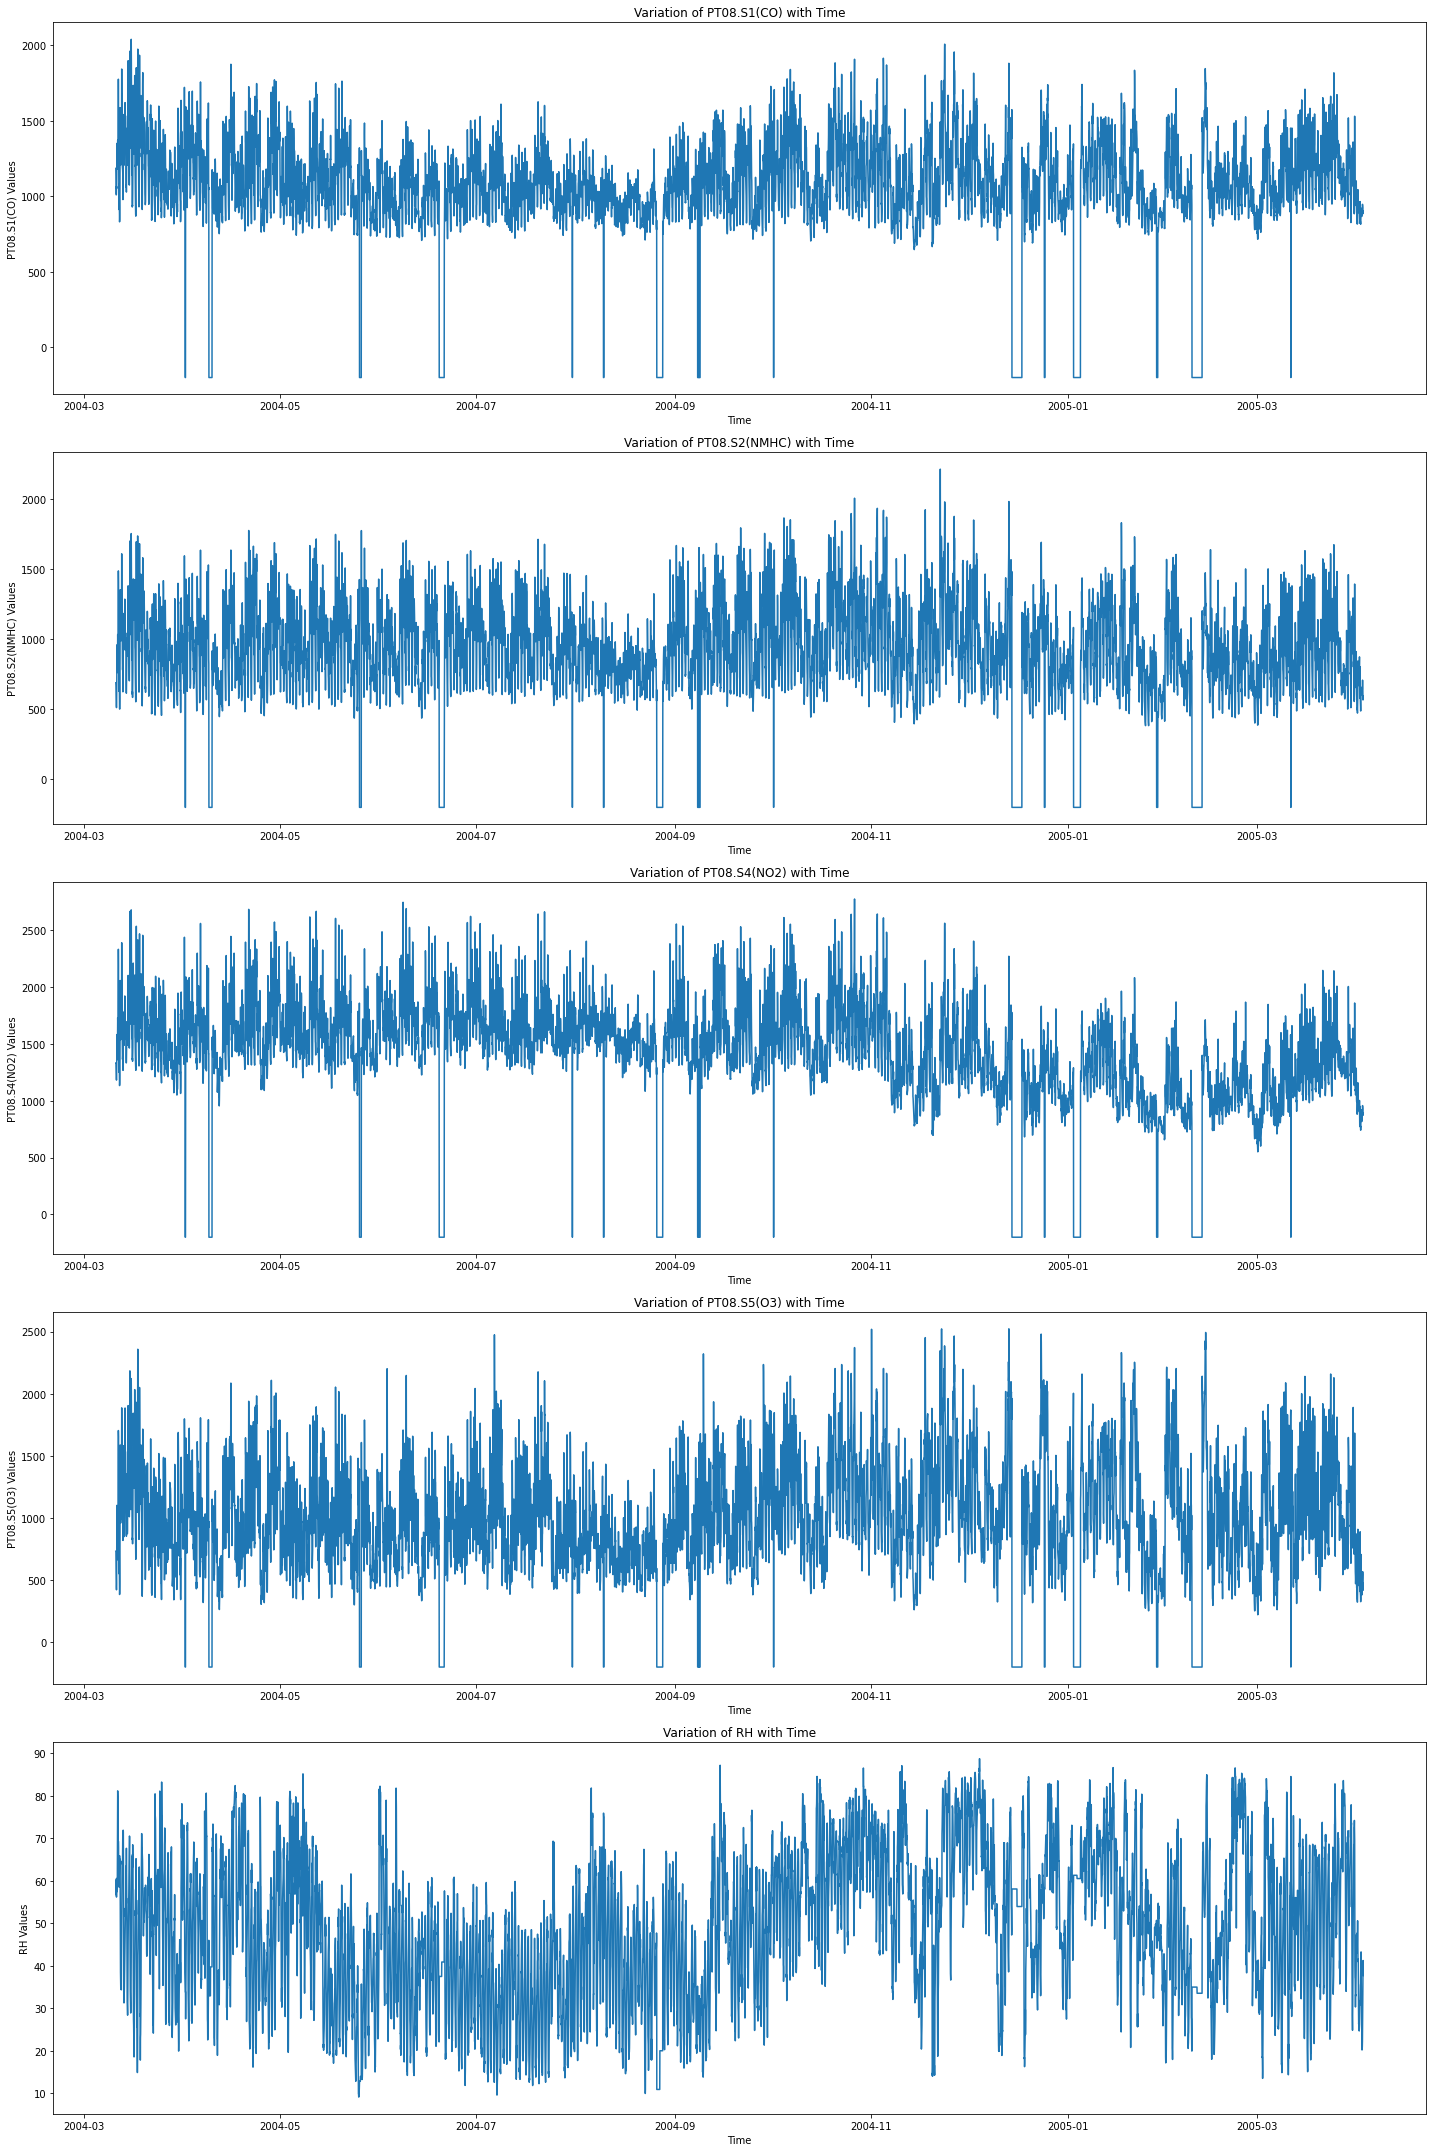

In [587]:
num_features = len(df.columns)

# Create a grid of subplots
fig, axes = plt.subplots(num_features, 1, figsize=(20, 6*num_features))  # Adjust the figure size as per your preference

for i, feature in enumerate(df.columns[:]):
    axes[i].plot(df[feature])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{feature} Values')
    axes[i].set_title(f'Variation of {feature} with Time')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [588]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S4(NO2),PT08.S5(O3),RH
Datetime,,,,,
2004-03-11 00:00:00,1185.00,689.50,1332.75,732.50,56.775000
2004-03-11 01:00:00,1136.25,672.00,1332.75,729.50,60.000000
2004-03-11 02:00:00,1094.00,608.50,1276.00,619.50,59.674999
2004-03-11 03:00:00,1009.75,560.75,1234.75,501.25,60.200001
2004-03-11 04:00:00,1011.00,526.75,1196.75,445.25,60.474999


In [589]:
from sklearn.preprocessing import MinMaxScaler

# We scale the features, while the target is left as it is.
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


## Feature Selection

In [590]:
df.head()

,PT08.S1(CO),PT08.S2(NMHC),PT08.S4(NO2),PT08.S5(O3),RH
Datetime,,,,,
2004-03-11 00:00:00,0.618373,0.368476,0.515210,0.342485,0.598366
2004-03-11 01:00:00,0.596607,0.361226,0.515210,0.341383,0.638906
2004-03-11 02:00:00,0.577743,0.334921,0.496134,0.300982,0.634821
2004-03-11 03:00:00,0.540127,0.315141,0.482269,0.257552,0.641420
2004-03-11 04:00:00,0.540685,0.301056,0.469496,0.236985,0.644877


In [591]:
df_target = pd.DataFrame(df_target)
df_target.head()

,C6H6(GT)
Datetime,
2004-03-11 00:00:00,3.624399
2004-03-11 01:00:00,3.326677
2004-03-11 02:00:00,2.339416
2004-03-11 03:00:00,1.696658
2004-03-11 04:00:00,1.293620


In [592]:
print('target shape: ', df_target.shape, ' feature shape: ', df.shape )

target shape:  (9312, 1)  feature shape:  (9312, 5)


Creating blocks of data - 1 week, 3 day, 1 day

In [593]:
def create_features_target(window, df, df_target):
    features_window = []
    target_window = []
    
    # Iterate over the data to create blocks
    for i in range(len(df) - window - 1):
        # Extract the feature data for the current block
        feature_block = pd.DataFrame(df.iloc[i:i+window])
        
        # Extract the target data for the next hour in the current block
        target_block = pd.DataFrame(df_target.iloc[i+window]).T

        feature_block = np.array(feature_block)
        target_block = np.array(target_block)
        
        # Append the feature and target data to the current time window lists
        features_window.append(feature_block.tolist())
        target_window.append(target_block[0][0].tolist())
    return np.array(features_window,dtype='float32'), np.array(target_window,dtype='float32')

# Define the time window sizes
time_windows = [24*1, 24*3, 24*7]  # 1 day, 3 days, 7 days
features_window1, target_window1 = create_features_target(time_windows[0], df, df_target)
features_window3, target_window3 = create_features_target(time_windows[1], df, df_target)
features_window7, target_window7 = create_features_target(time_windows[2], df, df_target)


In [594]:
# Printing the first block for each time window
print("1-Day Time Window:")
print(features_window1[0])
print(target_window1[0])
print('-'*20)
print("3-Day Time Window:")
print(features_window3[0])
print(target_window3[0])
print('-'*20)
print("7-Day Time Window:")
print(features_window7[0])
print(target_window7[0])

1-Day Time Window:
[[0.61837256 0.36847556 0.5152101  0.34248462 0.5983658 ]
 [0.5966068  0.36122617 0.5152101  0.3413828  0.63890636]
 [0.57774305 0.3349213  0.49613446 0.30098248 0.6348209 ]
 [0.5401272  0.31514084 0.4822689  0.25755212 0.6414205 ]
 [0.54068536 0.30105633 0.4694958  0.23698467 0.64487743]
 [0.56524163 0.29494613 0.46453783 0.22835368 0.59082335]
 [0.5588793  0.31203398 0.47773108 0.24662565 0.61533624]
 [0.60006696 0.35915494 0.5173109  0.34147462 0.63387805]
 [0.684563   0.45557165 0.57714283 0.47800937 0.60653675]
 [0.692488   0.4806338  0.5992437  0.4509228  0.64644873]
 [0.63991517 0.42553854 0.5531933  0.38922045 0.61816466]
 [0.6155821  0.3985087  0.52495795 0.31971353 0.6128221 ]
 [0.64114296 0.40358326 0.5382353  0.31732622 0.7240729 ]
 [0.66324365 0.44262636 0.58378154 0.36690846 0.84538025]
 [0.70141757 0.5109776  0.6488235  0.45413643 0.9047769 ]
 [0.6741824  0.46913835 0.6206723  0.4209898  0.8878064 ]
 [0.66603416 0.46043912 0.60193276 0.4248462  0.77906

In [595]:
print(features_window1.shape, target_window1.shape)

(9287, 24, 5) (9287,)


# TASK 2
Train and evaluate a neural network for **time series** (RNN or similar) to predict Benzene concentration at the 
next hour. You can use  Pytorch, Tensowflow(Keras) or Theano.

In [596]:
print(tabulate(df.head(), headers = df.columns, tablefmt = 'psql'))

+---------------------+---------------+-----------------+----------------+---------------+----------+
|                     |   PT08.S1(CO) |   PT08.S2(NMHC) |   PT08.S4(NO2) |   PT08.S5(O3) |       RH |
|---------------------+---------------+-----------------+----------------+---------------+----------|
| 2004-03-11 00:00:00 |      0.618373 |        0.368476 |       0.51521  |      0.342485 | 0.598366 |
| 2004-03-11 01:00:00 |      0.596607 |        0.361226 |       0.51521  |      0.341383 | 0.638906 |
| 2004-03-11 02:00:00 |      0.577743 |        0.334921 |       0.496134 |      0.300982 | 0.634821 |
| 2004-03-11 03:00:00 |      0.540127 |        0.315141 |       0.482269 |      0.257552 | 0.64142  |
| 2004-03-11 04:00:00 |      0.540685 |        0.301056 |       0.469496 |      0.236985 | 0.644877 |
+---------------------+---------------+-----------------+----------------+---------------+----------+


In [597]:
print(tabulate(df_target.head(), headers = df_target.columns, tablefmt = 'psql'))

+---------------------+------------+
|                     |   C6H6(GT) |
|---------------------+------------|
| 2004-03-11 00:00:00 |    3.6244  |
| 2004-03-11 01:00:00 |    3.32668 |
| 2004-03-11 02:00:00 |    2.33942 |
| 2004-03-11 03:00:00 |    1.69666 |
| 2004-03-11 04:00:00 |    1.29362 |
+---------------------+------------+


## NN Architecture

In [598]:
# transforming data into train, test, val
def data_split(feature, target):
    X_train, X_test, y_train, y_test = train_test_split(features_window1, target_window1, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, shuffle=False)

    print("size of X_train, y_train: ", X_train.shape, y_train.shape)
    print("size of X_test, y_test: ", X_test.shape, y_test.shape)
    print("size of X_val, y_val: ", X_val.shape, y_val.shape)
    
    return X_train, X_test, y_train, y_test, X_val, y_val

#preparing model
def modeling(X_train, X_test, y_train, y_test, X_val, y_val):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(24,5)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')

    # early stopping to prevent overfitting
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Evaluate model
    loss = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)

    # Plot the training and validation loss curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

# predicting the results of testSet, if trim_plot is 0, prints whole results.
def predict_testSet(model, X_test, y_test, trim_plot=0):
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Calculate metrics
    mse = metrics.mean_squared_error(y_test, y_pred)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    # Print the metrics
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("R-squared (R2) Score:", r2)
    
    # Lets plot the predicted values now
    # Ignore actual test values less than 0
    mask = y_test >= 0
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]
    
    # Plot actual vs predicted values
    plt.figure(figsize=(30, 6))
    
    #scatterplot
    # plt.scatter(range(len(y_test_filtered)), y_test_filtered, label='Actual')
    # plt.scatter(range(len(y_pred_filtered)), y_pred_filtered, label='Predicted')

    #lineplot
    indices = range(len(y_test_filtered))
    if trim_plot == 0:
        trim_plot = len(indices)
    if trim_plot>len(indices):
        print('Reduce the span of test cases to be printed!')
        return 
    plt.plot(indices[:trim_plot], y_test_filtered[:trim_plot], label='Actual')
    plt.plot(indices[:trim_plot], y_pred_filtered[:trim_plot], label='Predicted')

    plt.xlabel('Sample')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


### Observing results for 1-Day:

size of X_train, y_train:  (5571, 24, 5) (5571,)
size of X_test, y_test:  (1858, 24, 5) (1858,)
size of X_val, y_val:  (1858, 24, 5) (1858,)
Epoch 1/100
175/175 [==============================] - 6s 19ms/step - loss: 0.7973 - val_loss: 0.8332
Epoch 2/100
175/175 [==============================] - 3s 16ms/step - loss: 0.4892 - val_loss: 0.6761
Epoch 3/100
175/175 [==============================] - 3s 16ms/step - loss: 0.4430 - val_loss: 0.5119
Epoch 4/100
175/175 [==============================] - 4s 21ms/step - loss: 0.3874 - val_loss: 0.4725
Epoch 5/100
175/175 [==============================] - 3s 18ms/step - loss: 0.3321 - val_loss: 0.3651
Epoch 6/100
175/175 [==============================] - 3s 20ms/step - loss: 0.2593 - val_loss: 0.2955
Epoch 7/100
175/175 [==============================] - 3s 18ms/step - loss: 0.2355 - val_loss: 0.2779
Epoch 8/100
175/175 [==============================] - 3s 18ms/step - loss: 0.1998 - val_loss: 0.2567
Epoch 9/100
175/175 [======================

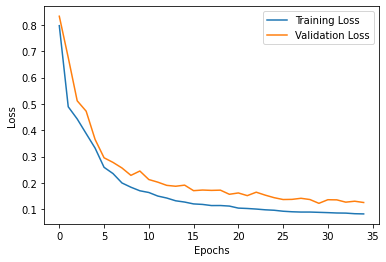

59/59 [==============================] - 1s 6ms/step
Mean Squared Error (MSE): 1819.8973
Mean Absolute Error (MAE): 11.161879
R-squared (R2) Score: 0.0665941777951723


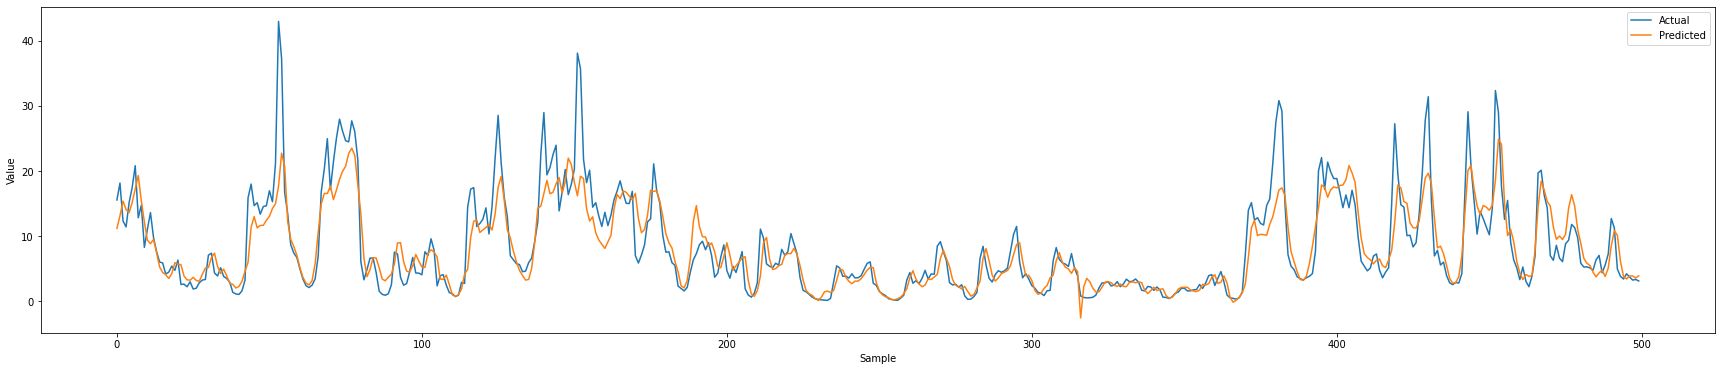

In [599]:
X_train1, X_test1, y_train1, y_test1, X_val1, y_val1 = data_split(features_window1, target_window1)
model1 = modeling(X_train1, X_test1, y_train1, y_test1, X_val1, y_val1)
predict_testSet(model1, X_test1, y_test1, 500)

### Observing results for 3-Day:

size of X_train, y_train:  (5571, 24, 5) (5571,)
size of X_test, y_test:  (1858, 24, 5) (1858,)
size of X_val, y_val:  (1858, 24, 5) (1858,)
Epoch 1/100
175/175 [==============================] - 7s 24ms/step - loss: 0.7196 - val_loss: 0.6346
Epoch 2/100
175/175 [==============================] - 4s 23ms/step - loss: 0.4753 - val_loss: 0.6543
Epoch 3/100
175/175 [==============================] - 4s 24ms/step - loss: 0.4275 - val_loss: 0.5095
Epoch 4/100
175/175 [==============================] - 4s 22ms/step - loss: 0.3882 - val_loss: 0.4477
Epoch 5/100
175/175 [==============================] - 5s 26ms/step - loss: 0.3281 - val_loss: 0.3834
Epoch 6/100
175/175 [==============================] - 4s 26ms/step - loss: 0.2682 - val_loss: 0.2807
Epoch 7/100
175/175 [==============================] - 5s 27ms/step - loss: 0.2225 - val_loss: 0.2514
Epoch 8/100
175/175 [==============================] - 5s 26ms/step - loss: 0.1984 - val_loss: 0.2528
Epoch 9/100
175/175 [======================

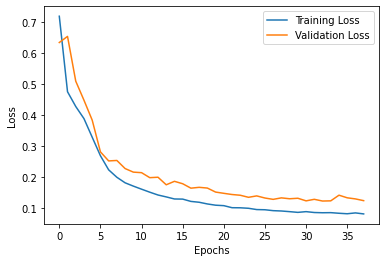

59/59 [==============================] - 2s 11ms/step
Mean Squared Error (MSE): 1808.3871
Mean Absolute Error (MAE): 11.088076
R-squared (R2) Score: 0.07249757089143694


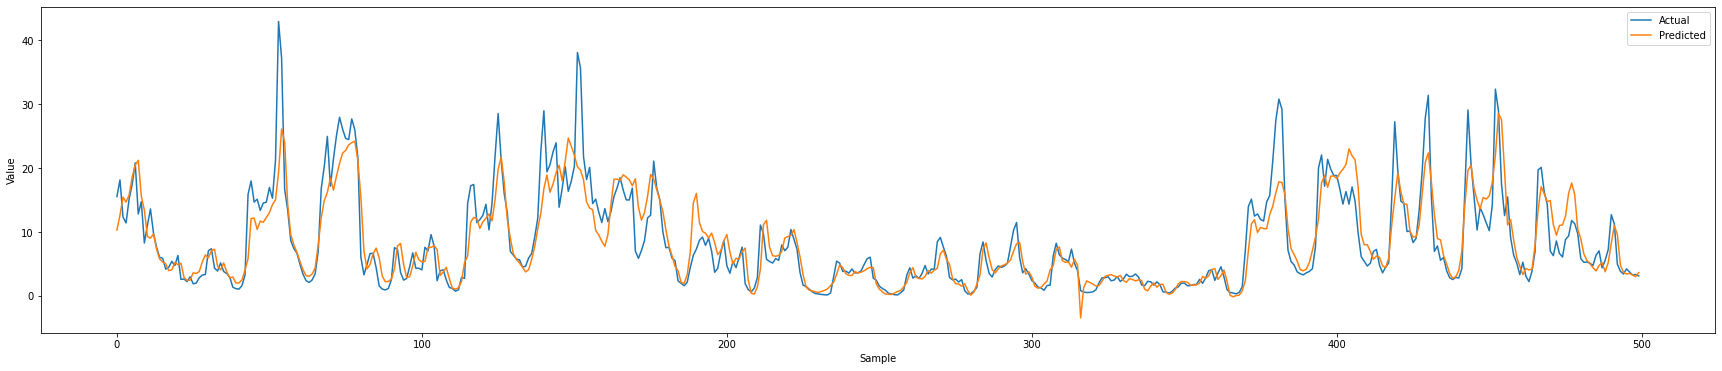

In [600]:
X_train3, X_test3, y_train3, y_test3, X_val3, y_val3 = data_split(features_window3, target_window3)
model3 = modeling(X_train3, X_test3, y_train3, y_test3, X_val3, y_val3)
predict_testSet(model3, X_test3, y_test3, 500)

### Observing results for 7-Day:

size of X_train, y_train:  (5571, 24, 5) (5571,)
size of X_test, y_test:  (1858, 24, 5) (1858,)
size of X_val, y_val:  (1858, 24, 5) (1858,)
Epoch 1/100
175/175 [==============================] - 7s 25ms/step - loss: 0.7402 - val_loss: 0.8122
Epoch 2/100
175/175 [==============================] - 4s 21ms/step - loss: 0.4817 - val_loss: 0.6071
Epoch 3/100
175/175 [==============================] - 4s 22ms/step - loss: 0.4240 - val_loss: 0.6244
Epoch 4/100
175/175 [==============================] - 4s 22ms/step - loss: 0.3911 - val_loss: 0.4379
Epoch 5/100
175/175 [==============================] - 4s 23ms/step - loss: 0.3521 - val_loss: 0.3693
Epoch 6/100
175/175 [==============================] - 4s 21ms/step - loss: 0.2632 - val_loss: 0.2796
Epoch 7/100
175/175 [==============================] - 5s 26ms/step - loss: 0.2298 - val_loss: 0.2391
Epoch 8/100
175/175 [==============================] - 4s 22ms/step - loss: 0.1891 - val_loss: 0.2337
Epoch 9/100
175/175 [======================

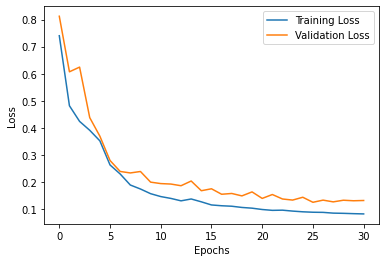

59/59 [==============================] - 1s 9ms/step
Mean Squared Error (MSE): 1843.4586
Mean Absolute Error (MAE): 11.259183
R-squared (R2) Score: 0.054509788934774206


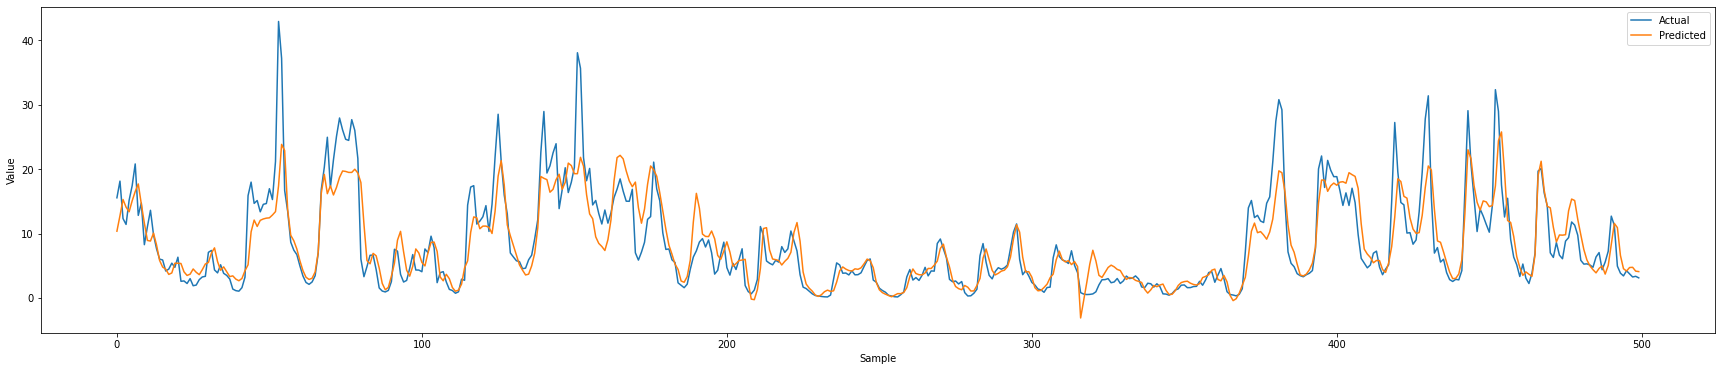

In [602]:
X_train7, X_test7, y_train7, y_test7, X_val7, y_val7 = data_split(features_window7, target_window7)
model7 = modeling(X_train7, X_test7, y_train7, y_test7, X_val7, y_val7)
predict_testSet(model7, X_test7, y_test7, 500)

### IMPLEMENTATION OF CLASSIFIER: 

1. Data splitting: Divide dataset into k subsets/folds of equal size.

2. Training and validation Iterations: Perform k iterations of training and evaluation, using one fold as validation & rest as training.

3. Model training &  evaluation: Train model on the training data and evaluate its prformance on the validation fold.

4. Performance metrics: Aggregate evaluation metrics from each iteration to obtain an overall prformance estimate.

5. Parameter tuning: Optionally, perform nested cross-validation within each iteration to fine-tune the model hyperparametr.